## Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
sns.set_style('whitegrid')

print("✓ Libraries imported")
print(f"Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Libraries imported
Execution time: 2025-12-10 16:50:35


In [2]:
# Load predictions
predictions_path = Path.cwd().parent / 'data' / 'gold' / 'predictions'
pred_file = predictions_path / 'msft_predictions.parquet'

if not pred_file.exists():
    print("❌ Predictions file not found")
    print("   Run Notebook 05 (05_prediction.ipynb) first to generate predictions.")
else:
    df_pred = pd.read_parquet(pred_file)
    df_pred = df_pred.sort_values('date').reset_index(drop=True)
    
    print(f"✓ Loaded {len(df_pred)} predictions")
    print(f"Date range: {df_pred['date'].min()} to {df_pred['date'].max()}")
    print("\nSignal distribution:")
    print(df_pred['prediction'].value_counts().sort_index())
    
    df_pred.head()

✓ Loaded 737 predictions
Date range: 2020-10-15 00:00:00-04:00 to 2025-12-03 00:00:00-05:00

Signal distribution:
prediction
-1     98
 0    527
 1    112
Name: count, dtype: int64


## Step 2: Backtest Configuration

In [3]:
# Backtest parameters
INITIAL_CAPITAL = 10000  # Starting portfolio value
TRANSACTION_COST = 0.001  # 0.1% per trade (realistic broker fees)
POSITION_SIZE = 1.0  # 100% of capital per trade (all-in strategy)

print("Backtest Configuration:")
print(f"  Initial Capital: ${INITIAL_CAPITAL:,.2f}")
print(f"  Transaction Cost: {TRANSACTION_COST*100:.2f}% per trade")
print(f"  Position Size: {POSITION_SIZE*100:.0f}% of capital")

Backtest Configuration:
  Initial Capital: $10,000.00
  Transaction Cost: 0.10% per trade
  Position Size: 100% of capital


## Step 3: Execute Backtest Simulation

In [4]:
# Initialize backtest variables
cash = INITIAL_CAPITAL
shares = 0
position = 'HOLD'  # Current position state: 'HOLD', 'LONG'
trades = []
portfolio_values = [INITIAL_CAPITAL]

# Run backtest
for i in range(len(df_pred) - 1):
    current = df_pred.iloc[i]
    signal = current['prediction']  # Use 'prediction' column (1=BUY, 0=HOLD, -1=SELL)
    price = current['close']
    
    # Calculate current portfolio value
    portfolio_value = cash + (shares * price)
    
    # Execute trades based on signals
    if signal == 1 and position == 'HOLD':  # BUY signal
        # Buy shares with available cash (minus transaction cost)
        trade_amount = cash * POSITION_SIZE
        cost = trade_amount * TRANSACTION_COST
        shares_to_buy = (trade_amount - cost) / price
        
        shares = shares_to_buy
        cash = cash - trade_amount
        position = 'LONG'
        
        trades.append({
            'date': current['date'],
            'action': 'BUY',
            'price': price,
            'shares': shares,
            'cost': cost,
            'portfolio_value': portfolio_value
        })
        
    elif signal == -1 and position == 'LONG':  # SELL signal
        # Sell all shares (minus transaction cost)
        proceeds = shares * price
        cost = proceeds * TRANSACTION_COST
        cash = cash + proceeds - cost
        
        trades.append({
            'date': current['date'],
            'action': 'SELL',
            'price': price,
            'shares': shares,
            'cost': cost,
            'portfolio_value': portfolio_value
        })
        
        shares = 0
        position = 'HOLD'
    
    # Track portfolio value
    portfolio_values.append(cash + (shares * price))

# Calculate final portfolio value
final_price = df_pred.iloc[-1]['close']
final_value = cash + (shares * final_price)
portfolio_values.append(final_value)

print("✓ Backtest complete")
print(f"  Total trades executed: {len(trades)}")
print(f"  Final position: {position}")
print(f"  Shares held: {shares:.2f}")
print(f"  Cash: ${cash:,.2f}")

✓ Backtest complete
  Total trades executed: 39
  Final position: LONG
  Shares held: 89.04
  Cash: $0.00


## Step 4: Calculate Performance Metrics

In [5]:
# Strategy performance
total_return = ((final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100
total_transaction_costs = sum(t['cost'] for t in trades)

# Buy & Hold benchmark
buy_hold_shares = INITIAL_CAPITAL / df_pred.iloc[0]['close']
buy_hold_value = buy_hold_shares * df_pred.iloc[-1]['close']
buy_hold_return = ((buy_hold_value - INITIAL_CAPITAL) / INITIAL_CAPITAL) * 100

# Alpha (excess return)
alpha = total_return - buy_hold_return

# Daily returns for risk metrics
portfolio_series = pd.Series(portfolio_values)
daily_returns = portfolio_series.pct_change().dropna()

# Sharpe Ratio (annualized, assuming 252 trading days)
risk_free_rate = 0.0  # Assume 0% risk-free rate
excess_returns = daily_returns - (risk_free_rate / 252)
sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252) if excess_returns.std() > 0 else 0

# Maximum Drawdown
running_max = portfolio_series.cummax()
drawdown = (portfolio_series - running_max) / running_max
max_drawdown = drawdown.min() * 100

# Volatility (annualized)
volatility = daily_returns.std() * np.sqrt(252) * 100

# Win Rate
buy_trades = [t for t in trades if t['action'] == 'BUY']
sell_trades = [t for t in trades if t['action'] == 'SELL']

winning_trades = 0
total_closed_trades = 0

for i in range(min(len(buy_trades), len(sell_trades))):
    buy_value = buy_trades[i]['shares'] * buy_trades[i]['price']
    sell_value = sell_trades[i]['shares'] * sell_trades[i]['price']
    if sell_value > buy_value:
        winning_trades += 1
    total_closed_trades += 1

win_rate = (winning_trades / total_closed_trades * 100) if total_closed_trades > 0 else 0

# Sortino Ratio (downside risk only)
downside_returns = daily_returns[daily_returns < 0]
downside_std = downside_returns.std()
sortino_ratio = (excess_returns.mean() / downside_std) * np.sqrt(252) if downside_std > 0 else 0

print("Performance metrics calculated ✓")

Performance metrics calculated ✓


## Step 5: Performance Summary

In [6]:
print("=" * 70)
print("BACKTEST RESULTS")
print("=" * 70)
print(f"Period: {df_pred['date'].min().strftime('%Y-%m-%d')} to {df_pred['date'].max().strftime('%Y-%m-%d')}")
print(f"Trading Days: {len(df_pred)}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,.2f}")

print(f"\n{'STRATEGY PERFORMANCE':^70}")
print("-" * 70)
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Return: {total_return:+.2f}%")
print(f"Number of Trades: {len(trades)}")
print(f"Transaction Costs: ${total_transaction_costs:,.2f}")

print(f"\n{'BUY & HOLD BENCHMARK':^70}")
print("-" * 70)
print(f"Final Value: ${buy_hold_value:,.2f}")
print(f"Total Return: {buy_hold_return:+.2f}%")

print(f"\n{'ALPHA & RISK METRICS':^70}")
print("-" * 70)
print(f"Alpha (vs Buy & Hold): {alpha:+.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Sortino Ratio: {sortino_ratio:.3f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"Volatility (annualized): {volatility:.2f}%")
print(f"Win Rate: {win_rate:.1f}% ({winning_trades}/{total_closed_trades} trades)")

print("\n" + "=" * 70)

# Interpretation
print("\n📊 INTERPRETATION:")
if alpha > 0:
    print(f"✓ Strategy OUTPERFORMED buy-and-hold by {alpha:.2f}%")
else:
    print(f"✗ Strategy UNDERPERFORMED buy-and-hold by {abs(alpha):.2f}%")

if sharpe_ratio > 1.0:
    print(f"✓ Sharpe Ratio {sharpe_ratio:.2f} indicates good risk-adjusted returns")
elif sharpe_ratio > 0:
    print(f"⚠ Sharpe Ratio {sharpe_ratio:.2f} indicates modest risk-adjusted returns")
else:
    print("✗ Negative Sharpe Ratio indicates poor risk-adjusted returns")

if win_rate > 50:
    print(f"✓ Win rate {win_rate:.1f}% is above 50% (profitable on average)")
else:
    print(f"⚠ Win rate {win_rate:.1f}% is below 50% (losses exceed wins)")

BACKTEST RESULTS
Period: 2020-10-15 to 2025-12-03
Trading Days: 737
Initial Capital: $10,000.00

                         STRATEGY PERFORMANCE                         
----------------------------------------------------------------------
Final Portfolio Value: $42,535.61
Total Return: +325.36%
Number of Trades: 39
Transaction Costs: $1,035.92

                         BUY & HOLD BENCHMARK                         
----------------------------------------------------------------------
Final Value: $22,725.01
Total Return: +127.25%

                         ALPHA & RISK METRICS                         
----------------------------------------------------------------------
Alpha (vs Buy & Hold): +198.11%
Sharpe Ratio: 2.617
Sortino Ratio: 2.455
Max Drawdown: -28.08%
Volatility (annualized): 19.67%
Win Rate: 84.2% (16/19 trades)


📊 INTERPRETATION:
✓ Strategy OUTPERFORMED buy-and-hold by 198.11%
✓ Sharpe Ratio 2.62 indicates good risk-adjusted returns
✓ Win rate 84.2% is above 50% (profita

## Step 6: Trade History

In [7]:
if trades:
    trades_df = pd.DataFrame(trades)
    trades_df['date'] = pd.to_datetime(trades_df['date']).dt.strftime('%Y-%m-%d')
    
    print("\n📋 TRADE HISTORY:")
    print("=" * 100)
    print(trades_df.to_string(index=False))
    
    # Trade summary
    buy_count = len([t for t in trades if t['action'] == 'BUY'])
    sell_count = len([t for t in trades if t['action'] == 'SELL'])
    
    print("\n" + "=" * 100)
    print(f"Total BUY signals: {buy_count}")
    print(f"Total SELL signals: {sell_count}")
    print(f"Open positions: {buy_count - sell_count}")
else:
    print("\n⚠ No trades executed (model may have predicted only HOLD)")


📋 TRADE HISTORY:
      date action      price     shares      cost  portfolio_value
2020-12-14    BUY 205.533417  48.605235 10.000000     10000.000000
2020-12-28   SELL 215.858078  48.605235 10.491833     10491.832586
2021-01-20    BUY 215.263153  48.642135 10.481341     10481.340753
2021-02-12   SELL 235.077667  48.642135 11.434680     11434.679690
2021-04-01    BUY 233.080063  48.960952 11.423245     11423.245011
2021-04-23   SELL 251.160950  48.960952 12.297079     12297.079198
2021-06-16    BUY 248.106705  49.464594 12.284782     12284.782119
2021-11-18   SELL 330.207031  49.464594 16.333557     16333.556630
2021-12-16    BUY 314.367676  51.852996 16.317223     16317.223073
2021-12-28   SELL 330.187592  51.852996 17.121216     17121.215880
2022-01-26    BUY 287.091522  59.517573 17.104095     17104.094664
2022-01-31   SELL 300.898895  59.517573 17.908772     17908.771900
2022-03-17    BUY 286.240479  62.440408 17.890863     17890.863128
2022-03-30   SELL 304.313446  62.440408 19.0

## Step 7: Visualization - Equity Curve


✓ Plot saved


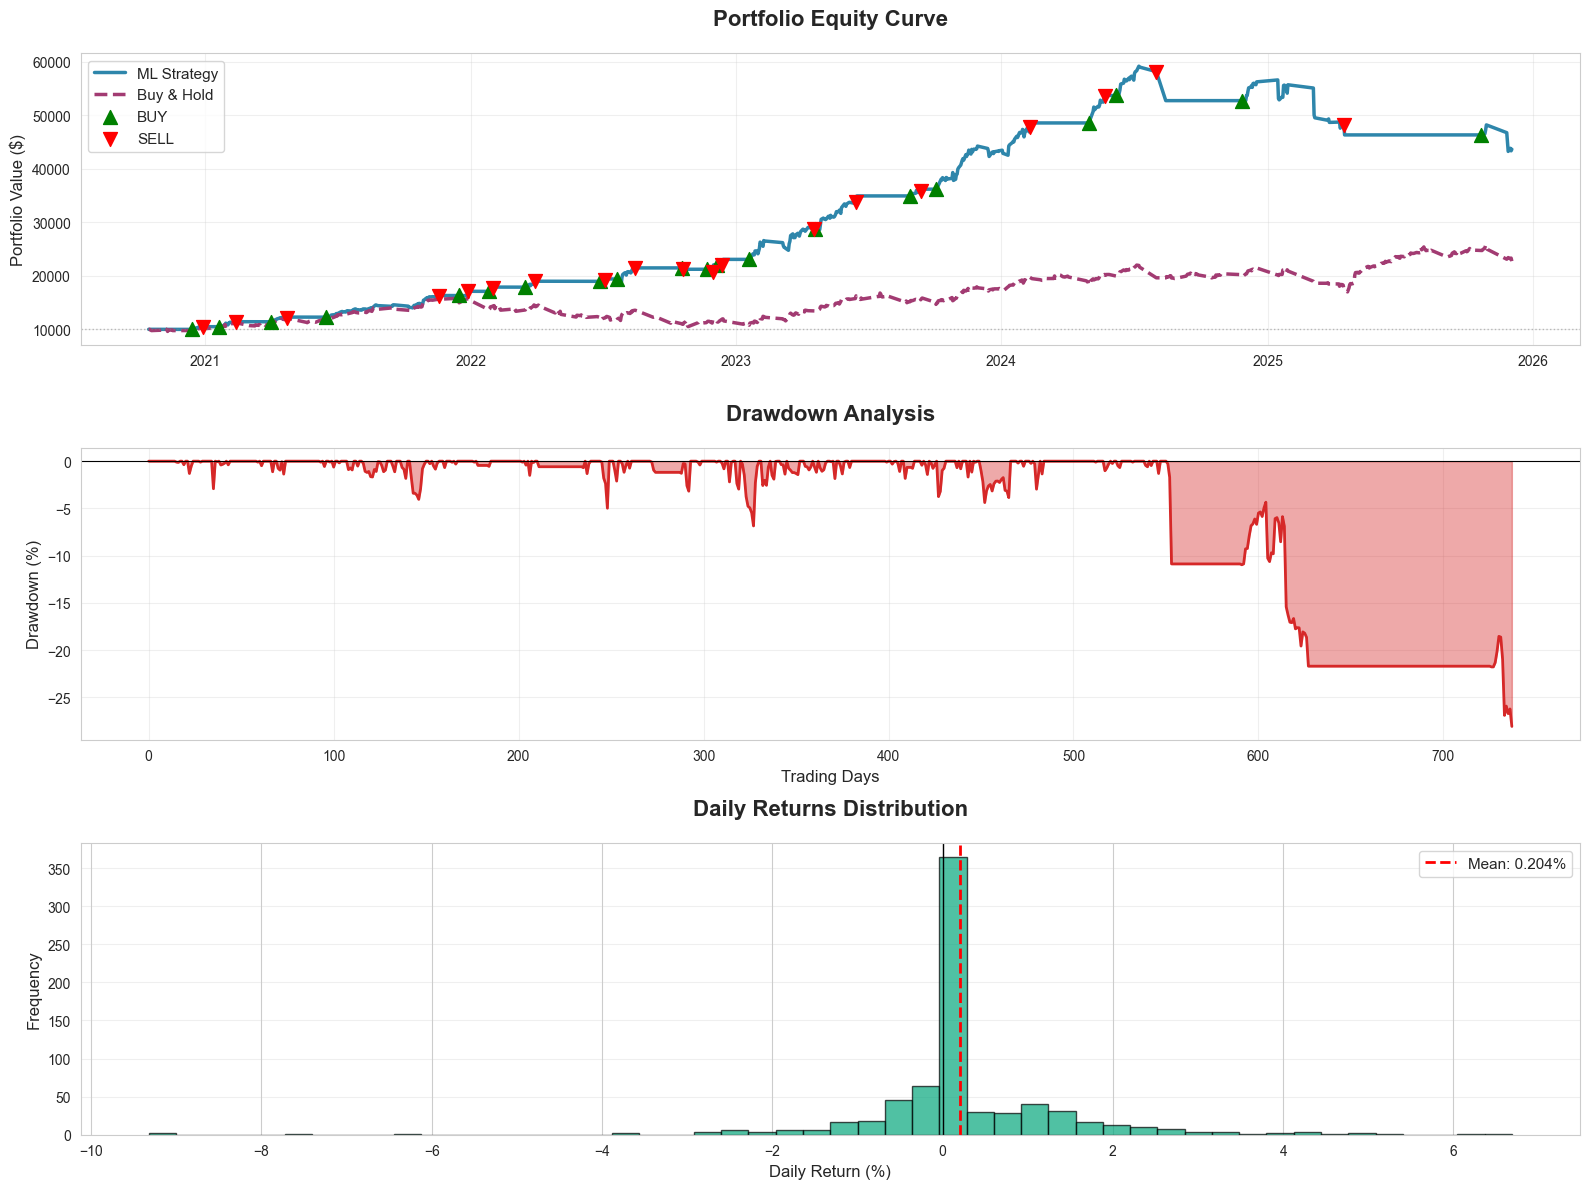

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Subplot 1: Portfolio Value Over Time
dates = df_pred['date'].tolist()

# Strategy equity curve
axes[0].plot(dates, portfolio_values[:-1], label='ML Strategy', linewidth=2.5, color='#2E86AB')

# Buy & hold benchmark
buy_hold_values = INITIAL_CAPITAL * (df_pred['close'] / df_pred['close'].iloc[0])
axes[0].plot(dates, buy_hold_values, label='Buy & Hold', linewidth=2.5, color='#A23B72', linestyle='--')

# Mark trades
if trades:
    buy_dates = [t['date'] for t in trades if t['action'] == 'BUY']
    buy_values = [portfolio_values[df_pred[df_pred['date'] == d].index[0]] for d in buy_dates]
    axes[0].scatter(buy_dates, buy_values, color='green', s=100, marker='^', label='BUY', zorder=5)
    
    sell_dates = [t['date'] for t in trades if t['action'] == 'SELL']
    sell_values = [portfolio_values[df_pred[df_pred['date'] == d].index[0]] for d in sell_dates]
    axes[0].scatter(sell_dates, sell_values, color='red', s=100, marker='v', label='SELL', zorder=5)

axes[0].set_title('Portfolio Equity Curve', fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].axhline(INITIAL_CAPITAL, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Subplot 2: Drawdown
axes[1].fill_between(range(len(drawdown)), drawdown * 100, 0, alpha=0.4, color='#D62828')
axes[1].plot(drawdown * 100, color='#D62828', linewidth=2)
axes[1].set_title('Drawdown Analysis', fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].set_xlabel('Trading Days', fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)

# Subplot 3: Daily Returns Distribution
axes[2].hist(daily_returns * 100, bins=50, alpha=0.7, color='#06A77D', edgecolor='black')
axes[2].axvline(daily_returns.mean() * 100, color='red', linestyle='--', linewidth=2, label=f'Mean: {daily_returns.mean()*100:.3f}%')
axes[2].axvline(0, color='black', linestyle='-', linewidth=1)
axes[2].set_title('Daily Returns Distribution', fontsize=16, fontweight='bold', pad=20)
axes[2].set_xlabel('Daily Return (%)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].legend(loc='best', fontsize=11)
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()

# Save plot to data directory
results_path = Path.cwd().parent / 'data' / 'gold' / 'backtest_results'
results_path.mkdir(parents=True, exist_ok=True)
plt.savefig(results_path / 'backtest_performance.png', dpi=300, bbox_inches='tight')
print("\n✓ Plot saved")

plt.show()

## Step 8: Monthly Returns Heatmap

✓ Heatmap saved


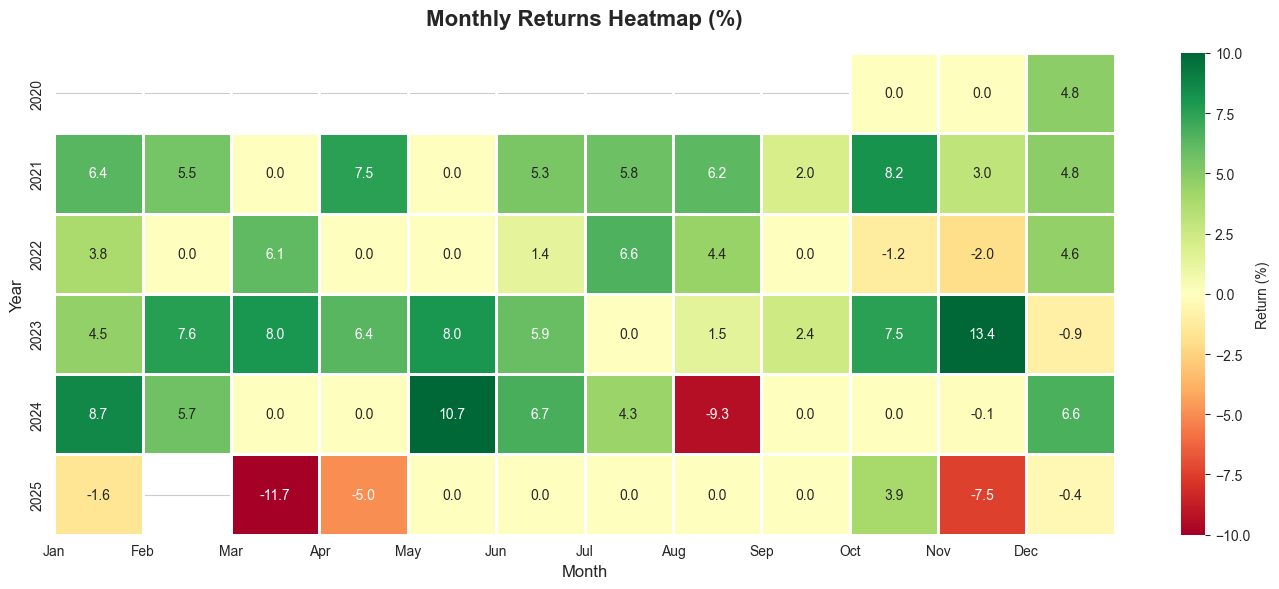

In [9]:
# Calculate monthly returns
df_returns = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values[:-1]
})

df_returns['date'] = pd.to_datetime(df_returns['date'])
df_returns['year'] = df_returns['date'].dt.year
df_returns['month'] = df_returns['date'].dt.month

# Calculate monthly returns
monthly_returns = df_returns.groupby(['year', 'month'])['portfolio_value'].apply(
    lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100 if len(x) > 0 else 0
).reset_index()

monthly_returns.columns = ['year', 'month', 'return']

# Pivot for heatmap
heatmap_data = monthly_returns.pivot(index='year', columns='month', values='return')

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
            linewidths=1, cbar_kws={'label': 'Return (%)'}, vmin=-10, vmax=10)
plt.title('Monthly Returns Heatmap (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.savefig(results_path / 'monthly_returns_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Heatmap saved")
plt.show()

## Step 9: Export Results

In [10]:
# Export summary to CSV
summary = pd.DataFrame({
    'Metric': [
        'Initial Capital',
        'Final Value',
        'Total Return (%)',
        'Buy & Hold Return (%)',
        'Alpha (%)',
        'Sharpe Ratio',
        'Sortino Ratio',
        'Max Drawdown (%)',
        'Volatility (%)',
        'Win Rate (%)',
        'Total Trades',
        'Transaction Costs ($)'
    ],
    'Value': [
        f"${INITIAL_CAPITAL:,.2f}",
        f"${final_value:,.2f}",
        f"{total_return:.2f}",
        f"{buy_hold_return:.2f}",
        f"{alpha:.2f}",
        f"{sharpe_ratio:.3f}",
        f"{sortino_ratio:.3f}",
        f"{max_drawdown:.2f}",
        f"{volatility:.2f}",
        f"{win_rate:.1f}",
        len(trades),
        f"${total_transaction_costs:.2f}"
    ]
})

summary.to_csv(results_path / 'backtest_summary.csv', index=False)
print("✓ Summary saved")

# Export trade history
if trades:
    trades_df.to_csv(results_path / 'backtest_trades.csv', index=False)
    print("✓ Trades saved")

print("\n" + "=" * 70)
print("BACKTEST COMPLETE")
print("=" * 70)

✓ Summary saved
✓ Trades saved

BACKTEST COMPLETE


## Next Steps

**If performance is positive (Alpha > 0):**
1. Test with different transaction costs (0.05%, 0.2%)
2. Implement position sizing (risk 2% per trade instead of all-in)
3. Add stop-loss rules (exit if position drops 5%)
4. Walk-forward testing (retrain quarterly, test next quarter)

**If performance is negative (Alpha < 0):**
1. Review false signals in trade history
2. Adjust percentile calibration thresholds (try top 20% instead of 30%)
3. Add more features to improve model accuracy
4. Try regression approach (predict returns instead of classes)

**Risk Management Improvements:**
- Implement trailing stop-loss
- Add position sizing based on volatility (ATR)
- Limit maximum drawdown (exit all positions if -15%)
- Diversify across multiple stocks

---
**Note**: Past performance does not guarantee future results. Always test strategies on out-of-sample data before live trading.